# Research on subscription plans

Research on which subscription plan gives a higher value to Megaline.

## Project description

As an analyst for the telecom operator Megaline, for the commercial department, I need to make a report on which of the plans, Surf or Ultimate, brings in more revenues in order to adjust the advertising budget.
There are some missing data, I don't know what is the cost for Megaline to let its users use each one of the activities (for example, how much the company pays for each GB it let her uses consume, or how much Megaline pays for connectivity - calling users from other companies require paying the other company some fees).
Therefore, the more the customer is paying, the more money the company is making. It's almost impossible that Megaline will earn more from the Surf plan customer which costs 20 dollars + extra fees rather than the Ultimate plan - 70 dollars.

The plans details are like that:<br>
<b>Surf</b>
<ul>
    <li>Monthly charge: $20</li>
    <li>500 monthly minutes, 50 texts, and 15 GB of data</li>
    <li>After exceeding the package limits:
        <ul>
        <li>1 minute: 3 cents</li>
        <li>1 text message: 3 cents</li>
        <li>1 GB of data: 10 dollars</li>
        </ul>
    </li>
</ul>

<br>

<b>Ultimate</b>
<ul>
    <li>Monthly charge: $70</li>
    <li>3000 monthly minutes, 1000 texts, and 30 GB of data</li>
    <li>After exceeding the package limits:
        <ul>
        <li>1 minute: 1 cents</li>
        <li>1 text message: 1 cents</li>
        <li>1 GB of data: 7 dollars</li>
        </ul>
    </li>
</ul>


## Data preperation

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from scipy import stats as st

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def load_data(file_name):
    df=''
    try:
        df=pd.read_csv(file_name)
    except:
        df=pd.read_csv('/datasets/{}'.format(file_name))
    return df

df_calls=load_data('megaline_calls.csv')
df_internet=load_data('megaline_internet.csv')
df_messages=load_data('megaline_messages.csv')
df_plans=load_data('megaline_plans.csv')
df_users=load_data('megaline_users.csv')

In [3]:
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [4]:
df_internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [5]:
df_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [6]:
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [7]:
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


### df_calls

In [8]:
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


We have calls with a duration of 0, which means that this is a call which the other user didn't receive. I won't do anything with it since it has no effect on the total duration of calls.

In [9]:
empty_calls_num=df_calls.query('duration==0')['duration'].count()
print('The number of empty calls (duration of call is 0): ',empty_calls_num)

The number of empty calls (duration of call is 0):  26834


Megaline rounds up the call's duration, so I'm adding a column for the rounded duration

In [10]:
df_calls['rounded_duration']=np.ceil(df_calls['duration'])

I'm creating a month column for grouping by month later, for that I'm changing the format of the column of the date from object to date.

In [11]:
df_calls['call_date']=pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls['month']=df_calls['call_date'].dt.month
df_calls.head()

,id,user_id,call_date,duration,rounded_duration,month
0,1000_93,1000,2018-12-27,8.52,9.0,12
1,1000_145,1000,2018-12-27,13.66,14.0,12
2,1000_247,1000,2018-12-27,14.48,15.0,12
3,1000_309,1000,2018-12-28,5.76,6.0,12
4,1000_380,1000,2018-12-30,4.22,5.0,12


### df_users

In [12]:
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [13]:
active_user=df_users.query('churn_date.isnull()')['churn_date'].count()
lost_user=df_users.query('churn_date.notnull()')['churn_date'].count()
num_of_users=len(df_users)
pct_lost_users=lost_user/num_of_users
print('The percent of users that left the company: {:.2%}'.format(pct_lost_users))

The percent of users that left the company: 6.80%


Because the data for users that left the company is not full and my effect the rest of the data, and the percent of it is very small, I'll drop those users.

In [14]:
df_users=df_users.query('churn_date.isnull()')

### df_internet

We have internet sessions for which usage is 0. It's probably a session that the user connected to the system, but didn't make any use of it. those lines do not affect the total outcome.

In [15]:
empty_net_sessions_num=df_internet.query('mb_used==0')['mb_used'].count()
print('The number of empty internet sessions (data usage is 0): ',empty_net_sessions_num)

The number of empty internet sessions (data usage is 0):  13747


I'm creating a month column for grouping by month later, for that I'm changing the format of the column of the date from object to date.

In [16]:
df_internet['session_date']=pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_internet['month']=df_internet['session_date'].dt.month
df_internet.head()

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


### df_messages

I'm creating a month column for grouping by month later, for that I'm changing the format of the column of the date from object to date.

In [17]:
df_messages['message_date']=pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_messages['month']=df_messages['message_date'].dt.month
df_messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


### Monthly Sum-ups

Calculate the next monthly sum-ups
<ul>
    <li>The number of calls made and minutes used per month</li>
    <li>The number of text messages sent per month</li>
    <li>The volume of data per month</li>
    <li>The monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan)</li>
</ul>
<br>
For my calculations, I'm adding the plan column from the users dataset.

In [18]:
df_calls_users=df_calls.merge(df_users, on='user_id', how='left')
df_calls_users.head(2)

,id,user_id,call_date,duration,rounded_duration,month,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000_93,1000,2018-12-27,8.52,9.0,12,Anamaria,Bauer,45.0,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1000_145,1000,2018-12-27,13.66,14.0,12,Anamaria,Bauer,45.0,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN


#### The number of calls made and minutes used per month

In [19]:
df_calls_pvt=df_calls_users.pivot_table(index=['user_id','month', 'plan'], values='rounded_duration', aggfunc=['count', 'sum'])
df_calls_pvt.columns=['calls_count', 'total_duration']

In [20]:
df_calls_pvt.head()

calls_count  total_duration
user_id month plan                                 
1000    12    ultimate           16           124.0
1001    8     surf               27           182.0
        9     surf               49           315.0
        10    surf               65           393.0
        11    surf               64           426.0

#### The number of text messages sent per month

In [21]:
df_messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


In [22]:
df_messages_users=df_messages.merge(df_users, on='user_id', how='left')
df_messages_users.head(2)

,id,user_id,message_date,month,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000_125,1000,2018-12-27,12,Anamaria,Bauer,45.0,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1000_160,1000,2018-12-31,12,Anamaria,Bauer,45.0,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN


In [23]:
df_messages_pvt=df_messages_users.pivot_table(index=['user_id','month','plan'], values='id', aggfunc='count')
df_messages_pvt.columns=['msg_count']
df_messages_pvt.head()

msg_count
user_id month plan               
1000    12    ultimate         11
1001    8     surf             30
        9     surf             44
        10    surf             53
        11    surf             36

#### The volume of data per month

In [24]:
df_internet.head()

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


In [25]:
df_internet_users=df_internet.merge(df_users, on='user_id', how='left')
df_internet_users.head(2)

,id,user_id,session_date,mb_used,month,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000_13,1000,2018-12-29,89.86,12,Anamaria,Bauer,45.0,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1000_204,1000,2018-12-31,0.00,12,Anamaria,Bauer,45.0,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN


In [26]:
df_internet_pvt=df_internet_users.pivot_table(index=['user_id','month','plan'], values='mb_used', aggfunc='sum')
df_internet_pvt.head()

mb_used
user_id month plan              
1000    12    ultimate   1901.47
1001    8     surf       6919.15
        9     surf      13314.82
        10    surf      22330.49
        11    surf      18504.30

Megaline rounds the monthly data usage up per gigabyte (1024 megabyte)

In [27]:
df_internet_pvt['mb_used_GB']=np.ceil(df_internet_pvt['mb_used']/1024)
df_internet_pvt.head()

mb_used  mb_used_GB
user_id month plan                          
1000    12    ultimate   1901.47         2.0
1001    8     surf       6919.15         7.0
        9     surf      13314.82        14.0
        10    surf      22330.49        22.0
        11    surf      18504.30        19.0

#### The monthly revenue from each user

subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan.<br>To do it, I'll calculate any extra payments the user made for any line of business (calls, internet, messages).

##### Extra payments - calls

In [28]:
def calc_extra_payment_calls(row):
    plan=row.name[2]
    duration=row['total_duration']
    free_duration=0
    dollar_per_minute=0
    
    if(plan=='surf'):
        free_duration=500
        dollar_per_minute=0.03
    else:
        free_duration=3000
        dollar_per_minute=0.01
        
    if duration<=free_duration:
        return 0
    else:
        return dollar_per_minute*(duration-free_duration)
    

df_calls_pvt['extra_payment_calls']=df_calls_pvt.apply(calc_extra_payment_calls, axis=1)
df_calls_pvt.query('extra_payment_calls>0').head()

calls_count  total_duration  extra_payment_calls
user_id month plan                                                  
1003    12    surf          149          1104.0                18.12
1007    10    surf           80           645.0                 4.35
        11    surf           80           524.0                 0.72
        12    surf           87           617.0                 3.51
1009    5     surf           71           534.0                 1.02

##### Extra payments - Messages

In [29]:
df_messages_pvt.head()

msg_count
user_id month plan               
1000    12    ultimate         11
1001    8     surf             30
        9     surf             44
        10    surf             53
        11    surf             36

In [30]:
def calc_extra_payment_messages(row):
    plan=row.name[2]
    msg_count=row['msg_count']
    free_messages=0
    dollar_per_message=0
    
    if(plan=='surf'):
        free_messages=50
        dollar_per_message=0.03
    else:
        free_messages=1000
        dollar_per_message=0.01
        
    if msg_count<=free_messages:
        return 0
    else:
        return dollar_per_message*(msg_count-free_messages)
    

df_messages_pvt['extra_payment_messages']=df_messages_pvt.apply(calc_extra_payment_messages, axis=1)
df_messages_pvt.query('extra_payment_messages>0').head()

msg_count  extra_payment_messages
user_id month plan                                   
1001    10    surf         53                    0.09
1007    8     surf         51                    0.03
        10    surf         59                    0.27
1014    12    surf         64                    0.42
1015    12    surf         68                    0.54

##### Extra payments - Internet

In [31]:
def calc_extra_payment_internet(row):
    plan=row.name[2]
    data=row['mb_used_GB']
    free_data=0
    dollar_per_gb=0
    
    if(plan=='surf'):
        free_data=15
        dollar_per_gb=0.03
    else:
        free_data=30
        dollar_per_gb=0.01
        
    if data<=free_data:
        return 0
    else:
        return dollar_per_gb*(data-free_data)
    

df_internet_pvt['extra_payment_internet']=df_internet_pvt.apply(calc_extra_payment_internet, axis=1)
df_internet_pvt.query('extra_payment_internet>0').head()

mb_used  mb_used_GB  extra_payment_internet
user_id month plan                                              
1001    10    surf  22330.49        22.0                    0.21
        11    surf  18504.30        19.0                    0.12
        12    surf  19369.18        19.0                    0.12
1002    11    surf  19345.08        19.0                    0.12
1003    12    surf  27044.14        27.0                    0.36

##### Extra payments - Merging all the data together

To calculate the revenue, I'm merging the datasets of each line of activity into one dataset

In [32]:
net_calls=pd.merge(df_internet_pvt, df_calls_pvt, on=['user_id','month','plan'])
net_calls.head()

mb_used  mb_used_GB  extra_payment_internet  \
user_id month plan                                                     
1000    12    ultimate   1901.47         2.0                    0.00   
1001    8     surf       6919.15         7.0                    0.00   
        9     surf      13314.82        14.0                    0.00   
        10    surf      22330.49        22.0                    0.21   
        11    surf      18504.30        19.0                    0.12   

                        calls_count  total_duration  extra_payment_calls  
user_id month plan                                                        
1000    12    ultimate           16           124.0                  0.0  
1001    8     surf               27           182.0                  0.0  
        9     surf               49           315.0                  0.0  
        10    surf               65           393.0                  0.0  
        11    surf               64           426.0                  0.0

In [33]:
net_calls_msgs=pd.merge(net_calls, df_messages_pvt, on=['user_id','month','plan'])
net_calls_msgs.head()

mb_used  mb_used_GB  extra_payment_internet  \
user_id month plan                                                     
1000    12    ultimate   1901.47         2.0                    0.00   
1001    8     surf       6919.15         7.0                    0.00   
        9     surf      13314.82        14.0                    0.00   
        10    surf      22330.49        22.0                    0.21   
        11    surf      18504.30        19.0                    0.12   

                        calls_count  total_duration  extra_payment_calls  \
user_id month plan                                                         
1000    12    ultimate           16           124.0                  0.0   
1001    8     surf               27           182.0                  0.0   
        9     surf               49           315.0                  0.0   
        10    surf               65           393.0                  0.0   
        11    surf               64           426.0                  0.0   

                        msg_count  extra_payment_messages  
user_id month plan                                         
1000    12    ultimate         11                    0.00  
1001    8     surf             30                    0.00  
        9     surf             44                    0.00  
        10    surf             53                    0.09  
        11    surf             36                    0.00

After merging the data, I'm calculating the revenue per month for each user

In [34]:
def calc_revenue(row):
    plan=row.name[2]
    extra=row['extra_payment_internet']+row['extra_payment_calls']+row['extra_payment_messages']
    payment=70
    if plan=='surf':
        payment=20
    total=payment+extra
    return total
    
net_calls_msgs['revenue']=net_calls_msgs.apply(calc_revenue, axis=1)

At the next table, the revenue per user per month is calculated. It is displayed in the revenue column

In [35]:
net_calls_msgs.head()

mb_used  mb_used_GB  extra_payment_internet  \
user_id month plan                                                     
1000    12    ultimate   1901.47         2.0                    0.00   
1001    8     surf       6919.15         7.0                    0.00   
        9     surf      13314.82        14.0                    0.00   
        10    surf      22330.49        22.0                    0.21   
        11    surf      18504.30        19.0                    0.12   

                        calls_count  total_duration  extra_payment_calls  \
user_id month plan                                                         
1000    12    ultimate           16           124.0                  0.0   
1001    8     surf               27           182.0                  0.0   
        9     surf               49           315.0                  0.0   
        10    surf               65           393.0                  0.0   
        11    surf               64           426.0                  0.0   

                        msg_count  extra_payment_messages  revenue  
user_id month plan                                                  
1000    12    ultimate         11                    0.00    70.00  
1001    8     surf             30                    0.00    20.00  
        9     surf             44                    0.00    20.00  
        10    surf             53                    0.09    20.30  
        11    surf             36                    0.00    20.12

In [36]:
revenue_user_month=net_calls_msgs[['revenue']]
revenue_user_month.head(10)

revenue
user_id month plan             
1000    12    ultimate    70.00
1001    8     surf        20.00
        9     surf        20.00
        10    surf        20.30
        11    surf        20.12
        12    surf        20.12
1002    10    surf        20.00
        11    surf        20.12
        12    surf        20.00
1003    12    surf        38.48

## Analyze the data

Here I need to analyze the user's usage of each line of activity of Megaline per plan per month.

In [37]:
net_calls_msgs.head()

mb_used  mb_used_GB  extra_payment_internet  \
user_id month plan                                                     
1000    12    ultimate   1901.47         2.0                    0.00   
1001    8     surf       6919.15         7.0                    0.00   
        9     surf      13314.82        14.0                    0.00   
        10    surf      22330.49        22.0                    0.21   
        11    surf      18504.30        19.0                    0.12   

                        calls_count  total_duration  extra_payment_calls  \
user_id month plan                                                         
1000    12    ultimate           16           124.0                  0.0   
1001    8     surf               27           182.0                  0.0   
        9     surf               49           315.0                  0.0   
        10    surf               65           393.0                  0.0   
        11    surf               64           426.0                  0.0   

                        msg_count  extra_payment_messages  revenue  
user_id month plan                                                  
1000    12    ultimate         11                    0.00    70.00  
1001    8     surf             30                    0.00    20.00  
        9     surf             44                    0.00    20.00  
        10    surf             53                    0.09    20.30  
        11    surf             36                    0.00    20.12

First of all, creating 2 datasets one for each plan.

In [38]:
surf_net_calls_msgs=net_calls_msgs.query('plan=="surf"')
ultimate_net_calls_msgs=net_calls_msgs.query('plan!="surf"')
surf_net_calls_msgs.head()
ultimate_net_calls_msgs.head()

mb_used  mb_used_GB  extra_payment_internet  calls_count  \
user_id month plan                                                              
1001    8     surf   6919.15         7.0                    0.00           27   
        9     surf  13314.82        14.0                    0.00           49   
        10    surf  22330.49        22.0                    0.21           65   
        11    surf  18504.30        19.0                    0.12           64   
        12    surf  19369.18        19.0                    0.12           56   

                    total_duration  extra_payment_calls  msg_count  \
user_id month plan                                                   
1001    8     surf           182.0                  0.0         30   
        9     surf           315.0                  0.0         44   
        10    surf           393.0                  0.0         53   
        11    surf           426.0                  0.0         36   
        12    surf           412.0                  0.0         44   

                    extra_payment_messages  revenue  
user_id month plan                                   
1001    8     surf                    0.00    20.00  
        9     surf                    0.00    20.00  
        10    surf                    0.09    20.30  
        11    surf                    0.00    20.12  
        12    surf                    0.00    20.12

mb_used  mb_used_GB  extra_payment_internet  \
user_id month plan                                                     
1000    12    ultimate   1901.47         2.0                     0.0   
1008    10    ultimate  17106.99        17.0                     0.0   
        11    ultimate  23676.72        24.0                     0.0   
        12    ultimate  14689.33        15.0                     0.0   
1011    6     ultimate   6685.11         7.0                     0.0   

                        calls_count  total_duration  extra_payment_calls  \
user_id month plan                                                         
1000    12    ultimate           16           124.0                  0.0   
1008    10    ultimate           71           476.0                  0.0   
        11    ultimate           63           446.0                  0.0   
        12    ultimate           85           634.0                  0.0   
1011    6     ultimate           19           118.0                  0.0   

                        msg_count  extra_payment_messages  revenue  
user_id month plan                                                  
1000    12    ultimate         11                     0.0     70.0  
1008    10    ultimate         21                     0.0     70.0  
        11    ultimate         37                     0.0     70.0  
        12    ultimate         26                     0.0     70.0  
1011    6     ultimate         21                     0.0     70.0

In [39]:
num_all_users=len(net_calls_msgs)
num_ultimate=len(ultimate_net_calls_msgs)
num_surf=len(surf_net_calls_msgs)
print("Percent of Surf plan's users: {:.2%}".format(num_surf/num_all_users))
print("Percent of Ultimate plan's users: {:.2%}".format(num_ultimate/num_all_users))

Percent of Surf plan's users: 67.28%
Percent of Ultimate plan's users: 32.72%


### Surf plan analysis

<b>Surf</b>
<ul>
    <li>Monthly charge: $20</li>
    <li>500 monthly minutes, 50 texts, and 15 GB of data</li>
    <li>After exceeding the package limits:
        <ul>
        <li>1 minute: 3 cents</li>
        <li>1 text message: 3 cents</li>
        <li>1 GB of data: 10 dollars</li>
        </ul>
    </li>
</ul>

The statistics of the surf plan is:

In [40]:
surf_net_calls_msgs.describe()

,mb_used,mb_used_GB,extra_payment_internet,calls_count,total_duration,extra_payment_calls,msg_count,extra_payment_messages,revenue
count,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000
mean,16662.263732,16.785326,0.114266,62.518116,447.778986,2.073967,39.497283,0.262663,22.450897
std,7710.175935,7.544736,0.157881,32.275441,237.082999,4.104218,32.673000,0.637449,4.364107
min,92.310000,1.000000,0.000000,1.000000,2.000000,0.000000,1.000000,0.000000,20.000000
25%,12510.760000,13.000000,0.000000,41.000000,290.750000,0.000000,16.000000,0.000000,20.030000
50%,16847.265000,17.000000,0.060000,62.000000,440.000000,0.000000,31.500000,0.000000,20.390000
75%,20995.597500,21.000000,0.180000,81.000000,590.000000,2.700000,53.000000,0.090000,23.247500
max,70931.590000,70.000000,1.650000,205.000000,1510.000000,30.300000,266.000000,6.480000,53.210000


Looking at the describe function's output we can see that most of the users are staying within the limits of the Surf plan. The mean revenue is 22.45, not far from the plan's cost which is 20$. We can also see that up to 20.39 are 50% of the users, which is few cents over the plan's cost. <br>
Even the highest paying customer, is paying 53 dollars, which is much lower than 70 dollars of the Ultimate plan

Histagram showing the users behavior for the main parameters of that plan.

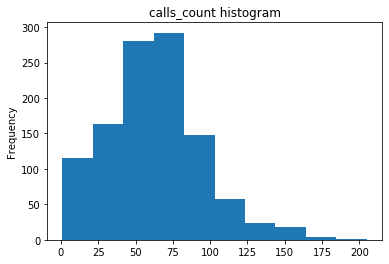

In [72]:
surf_net_calls_msgs['calls_count'].plot(kind='hist',title='calls_count histogram');
plt.show();

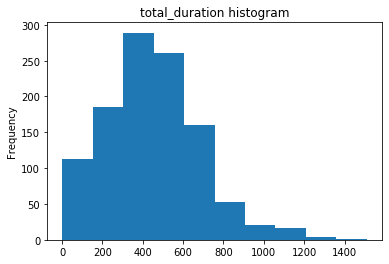

In [78]:
surf_net_calls_msgs['total_duration'].plot(kind='hist',title='total_duration (calls) histogram');
plt.show();

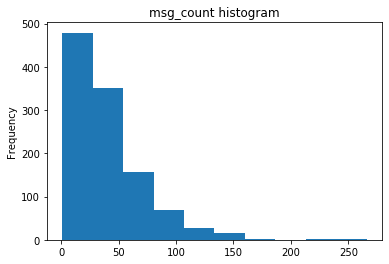

In [79]:
surf_net_calls_msgs['msg_count'].plot(kind='hist',title='msg_count histogram');
plt.show();

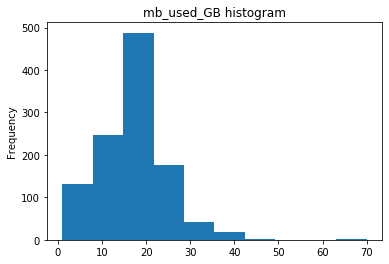

In [80]:
surf_net_calls_msgs['mb_used_GB'].plot(kind='hist',title='mb_used_GB histogram');
plt.show();

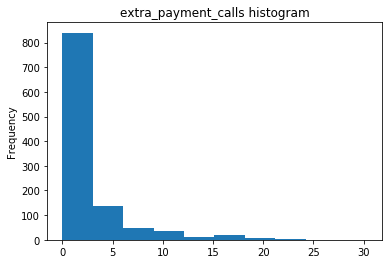

In [77]:
surf_net_calls_msgs['extra_payment_calls'].plot(kind='hist',title='extra_payment_calls histogram');
plt.show();

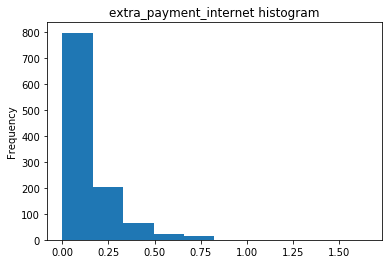

In [76]:
surf_net_calls_msgs['extra_payment_internet'].plot(kind='hist',title='extra_payment_internet histogram');
plt.show();

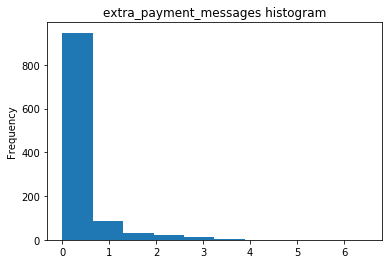

In [75]:
surf_net_calls_msgs['extra_payment_messages'].plot(kind='hist',title='extra_payment_messages histogram');
plt.show();

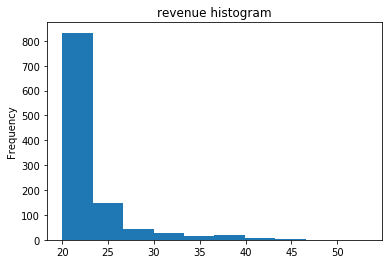

In [73]:
surf_net_calls_msgs['revenue'].plot(kind='hist',title='revenue histogram');
plt.show();

Looking at the histogram we can see that most of the users are staying within the limits of the plan, maybe deviate in few cents. From the describe function, 75% of the users are up to 23.25.

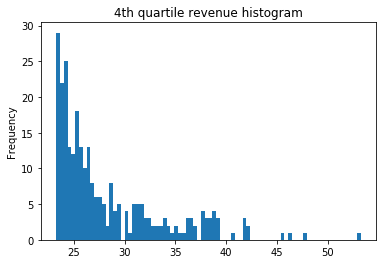

In [81]:
rev=surf_net_calls_msgs.query('revenue>23.25')['revenue']
rev.plot(kind='hist', bins=80,title='4th quartile revenue histogram');
plt.show();

### Ultimate plan analysis

<b>Ultimate</b>
<ul>
    <li>Monthly charge: $70</li>
    <li>3000 monthly minutes, 1000 texts, and 30 GB of data</li>
    <li>After exceeding the package limits:
        <ul>
        <li>1 minute: 1 cents</li>
        <li>1 text message: 1 cents</li>
        <li>1 GB of data: 7 dollars</li>
        </ul>
    </li>
</ul>


In [43]:
ultimate_net_calls_msgs.describe()

,mb_used,mb_used_GB,extra_payment_internet,calls_count,total_duration,extra_payment_calls,msg_count,extra_payment_messages,revenue
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.0,537.000000,537.0,537.000000
mean,17354.912067,17.443203,0.003408,62.348231,443.132216,0.0,47.486034,0.0,70.003408
std,7760.756491,7.566190,0.016326,34.991680,253.332997,0.0,33.171427,0.0,0.016326
min,290.060000,1.000000,0.000000,2.000000,0.000000,0.0,1.000000,0.0,70.000000
25%,12728.120000,13.000000,0.000000,36.000000,259.000000,0.0,22.000000,0.0,70.000000
50%,16908.690000,17.000000,0.000000,61.000000,424.000000,0.0,42.000000,0.0,70.000000
75%,21003.900000,21.000000,0.000000,82.000000,583.000000,0.0,68.000000,0.0,70.000000
max,46595.330000,46.000000,0.160000,191.000000,1369.000000,0.0,166.000000,0.0,70.160000


From the describe function I see that there are almost no deviations from the Ultimate's plan limitations.

In [44]:
deviated_users=ultimate_net_calls_msgs.query('revenue>70')
deviated_num=len(deviated_users)
ultimate_user_num=len(ultimate_net_calls_msgs)
pct_deviate_users=deviated_num/ultimate_user_num
print("The percent of users who deviated from the Ultimate plan's limitations are {:.2%}".format(pct_deviate_users))

The percent of users who deviated from the Ultimate plan's limitations are 5.77%


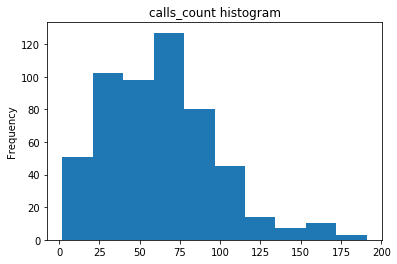

In [89]:
ultimate_net_calls_msgs['calls_count'].plot(kind='hist',title='calls_count histogram');
plt.show();

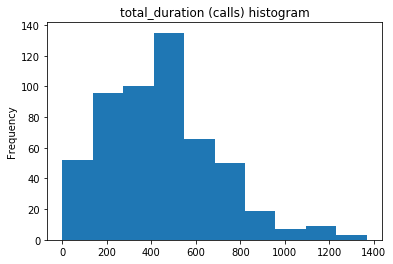

In [88]:
ultimate_net_calls_msgs['total_duration'].plot(kind='hist',title='total_duration (calls) histogram');
plt.show();

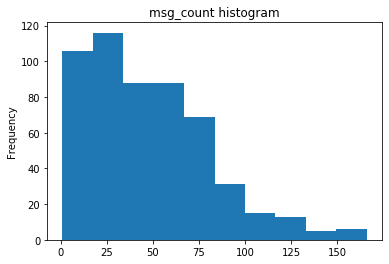

In [87]:
ultimate_net_calls_msgs['msg_count'].plot(kind='hist',title='msg_count histogram');
plt.show();

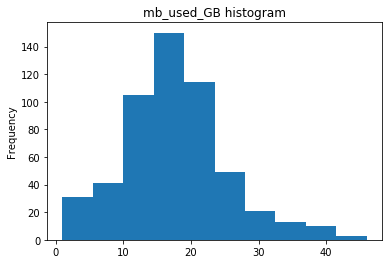

In [86]:
ultimate_net_calls_msgs['mb_used_GB'].plot(kind='hist',title='mb_used_GB histogram');
plt.show();

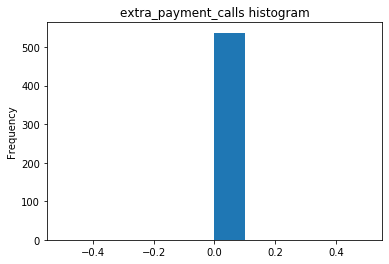

In [85]:
ultimate_net_calls_msgs['extra_payment_calls'].plot(kind='hist',title='extra_payment_calls histogram');
plt.show();

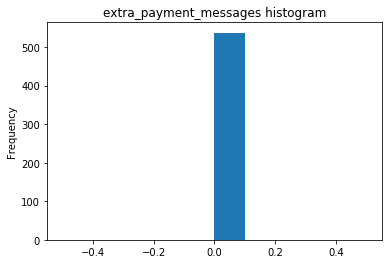

In [84]:
ultimate_net_calls_msgs['extra_payment_messages'].plot(kind='hist',title='extra_payment_messages histogram');
plt.show();

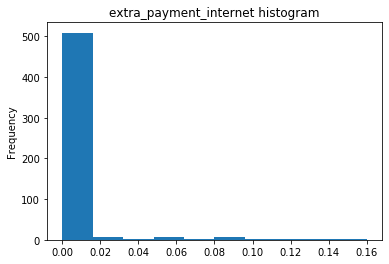

In [90]:
ultimate_net_calls_msgs['extra_payment_internet'].plot(kind='hist',title='extra_payment_internet histogram');
plt.show();

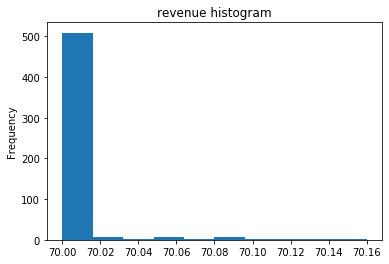

In [82]:
ultimate_net_calls_msgs['revenue'].plot(kind='hist',title='revenue histogram');
plt.show();

The only deviation is at the data consumption. Every GB consumed over 30 is a deviation.

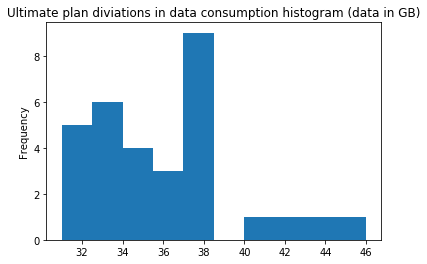

In [61]:
deviated_users['mb_used_GB'].plot(kind='hist',title='Ultimate plan diviations in data consumption histogram (data in GB)')
plt.show();

Although there are almost no deviations from the plan's limitation, and therefore there are no extra payments, each user is paying 70 dollars, which is much more than the cost of the Surf plan.

## Test the hypothesis

###	The average revenue from users of Ultimate and Surf calling plans differs.

The Surf plan is much smaller in all aspects than the Ultimate plan (number of messages, minutes, and data package size). A small plan leads to exceeding the free quota and paying extra fees. I saw earlier that the Ultimate plan users almost don't pay extra fees.<br>
The null hypothesis is that users from both plans pays the same avaregly.
The alternative hypothesis that I want to check is whether the average revenue from users of Ultimate and Surf calling plans differs.
<br><br>
To check it, I'll calculate the avarege revenue for both groups.

In [47]:
ultimate_net_calls_msgs['revenue'].mean()
surf_net_calls_msgs['revenue'].mean()
ultimate_net_calls_msgs['revenue'].mean()/surf_net_calls_msgs['revenue'].mean()

70.00340782122905

22.450896739130435

3.118067337560629

I got that there is a significant difference between the 2 groups revenue. The Ultimate plan's average revenue is more than 3 times bigger than the surf's plan average revenue. No metter how much extra fees are paid, the average revenue from the Ultimate plan is significantly bigger.

###	The average revenue from users in NY-NJ area is different from that of the users from other regions.

The null hypothesis is that although the users come from different areas, the average revenue for each group will be the same.<br>
The alternative hypothesis that I need to check is wether the average revenue from users in the NY-NJ area is different from that of the users from other regions.

First of all, I'm creating 2 datasets, 1 for users from NY-NJ, the other dataset is from all other areas.

In [48]:
df_user_city=df_users[['user_id','city']]
df_user_city.head(3)

,user_id,city
0,1000,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,"Seattle-Tacoma-Bellevue, WA MSA"
2,1002,"Las Vegas-Henderson-Paradise, NV MSA"


In [49]:
df_ny_users=df_user_city.query('city.str.contains("NY-NJ")')
df_not_ny_users=df_user_city.query('~city.str.contains("NY-NJ")')

net_calls_msgs_ny=net_calls_msgs.merge(df_ny_users, on='user_id', how='inner')
net_calls_msgs_not_ny=net_calls_msgs.merge(df_not_ny_users, on='user_id', how='inner')

net_calls_msgs_ny.head(2)
net_calls_msgs_not_ny.head(2)

,user_id,mb_used,mb_used_GB,extra_payment_internet,calls_count,total_duration,extra_payment_calls,msg_count,extra_payment_messages,revenue,city
0,1014,1175.59,2.0,0.0,28,163.0,0.00,9,0.00,20.00,"New York-Newark-Jersey City, NY-NJ-PA MSA"
1,1014,7792.41,8.0,0.0,150,1114.0,18.42,64,0.42,38.84,"New York-Newark-Jersey City, NY-NJ-PA MSA"


,user_id,mb_used,mb_used_GB,extra_payment_internet,calls_count,total_duration,extra_payment_calls,msg_count,extra_payment_messages,revenue,city
0,1000,1901.47,2.0,0.0,16,124.0,0.0,11,0.0,70.0,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,6919.15,7.0,0.0,27,182.0,0.0,30,0.0,20.0,"Seattle-Tacoma-Bellevue, WA MSA"


To check the hypothesis, I'll compare the hypothesis on the equality of two population means

In [50]:
results = st.ttest_ind(net_calls_msgs_not_ny['revenue'],net_calls_msgs_ny['revenue'])
alpha = 0.05  # critical statistical significance level
if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis") 

We reject the null hypothesis


The alpha that I used is the margins on both sides of the normal distributions Gaus curve. I used a value of 5% (2.5% from each side of the graph) as it is the commonly used value for the rejected values.

## overall conclusion

The average revenue from users from the Ultimate plan is significantly higher than the revenue from the Surf plan.<br>
Since there are some missing data regarding the operational cost of each service Megaline lets its users consume, I can't calculate the cost of each user to Megaline, so I can't tell whether this user is profitable. Therefore, the more the customer pays, the higher the revenue is.
<br><br>
My suggestion to the advertising team is to try to get more users to the Ultimate plan